<a href="https://colab.research.google.com/github/Pritush09/DeepLearning-Pytorch/blob/master/03_Computer_Vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
!pip install mplcyberpunk
import mplcyberpunk
plt.style.use("cyberpunk")

In [3]:
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

print(torchvision.__version__)

0.16.0+cu118


# Getting Data

Dataset which we are using is the fashionmnist dataset from [torchvision.datasets.FashionMNIST](https://pytorch.org/vision/stable/generated/torchvision.datasets.FashionMNIST.html#torchvision.datasets.FashionMNIST)


In [4]:
# Setup training data
train_data = datasets.FashionMNIST(
    root="data", # where to download data to?
    train=True, # get training data
    download=True, # download data if it doesn't exist on disk
    transform=ToTensor(), # images come as PIL format, we want to turn into Torch tensors
    target_transform=None # you can transform labels as well
)

# Setup testing data
test_data = datasets.FashionMNIST(
    root="data",
    train=False, # get test data
    download=True,
    transform=ToTensor()
)

100%|██████████| 26421880/26421880 [00:01<00:00, 17683113.25it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 270615.93it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 4929038.10it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 20447232.00it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [5]:
len(train_data) , len(test_data)

(60000, 10000)

In [6]:
img , label = train_data[0]

In [7]:
class_label = train_data.classes

In [8]:
train_data.class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

(-0.5, 27.5, 27.5, -0.5)

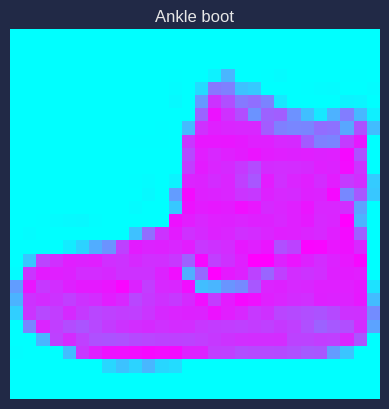

In [9]:
# Visualizing the image

plt.imshow(img.reshape(28,28,1)) # or u can use squeeze() function
plt.title(class_label[label])
plt.axis(False)

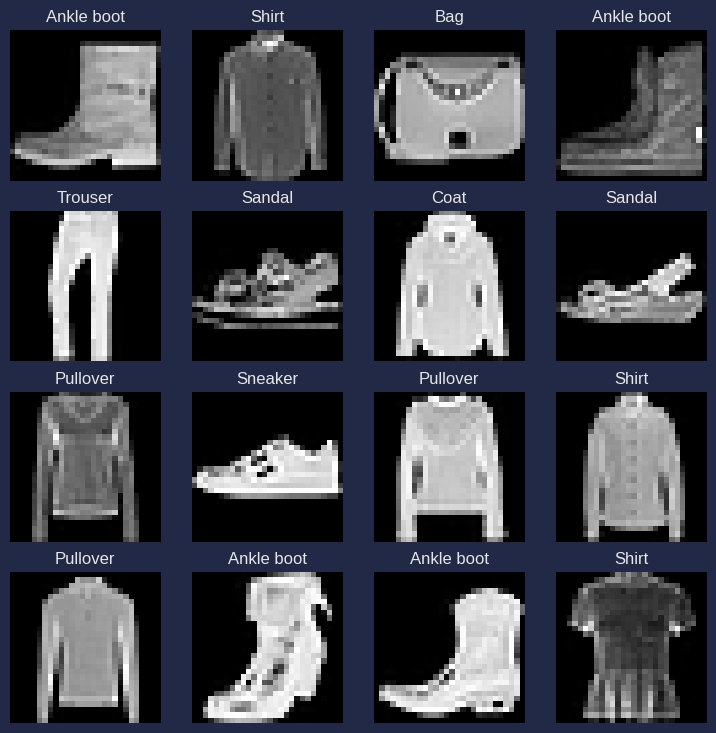

In [10]:
torch.manual_seed(42)
fig  = plt.figure(figsize=(9,9))
rows , cols = 4,4
for i in range(1,rows*cols+1):
  random_idx = torch.randint(low = 0,high = len(train_data),size=[1]).item()
  img , label = train_data[random_idx]
  fig.add_subplot(rows, cols, i)
  plt.imshow(img.squeeze(), cmap="gray")
  plt.title(class_label[label])
  plt.axis(False);

# Prepare DataLoader

Now our data is in the form of pytorch dataset

Dataloader turns our dataset into Python iterable

we want to turn our data into batches (or mini batches)

Why we would do this ?

1. It is more computationally efficient as in out computing hardware may not be able to look (store in memory) at 60k images in one hit. so we break it down to 32 images at a time (batches of 32)
2. it gives our neural network more chances to update its parameters per epoch


In [11]:
from torch.utils.data import DataLoader

# Setup the batch Size it is a hyper parameter
BATCH_SIZE = 32

# Turn datasets into iterable (batches)
train_dataloader = DataLoader(
                        dataset=train_data,
                        batch_size=BATCH_SIZE,
                        shuffle=True
                    )

test_dataloader = DataLoader(dataset=test_data,
                        batch_size=BATCH_SIZE,
                        shuffle=True
                    )

In [12]:
len(train_dataloader) , len(test_dataloader)

(1875, 313)

In [13]:
# Check out whatt inside the training dataloader
train_features_batch , train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape , train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

(-0.5, 27.5, 27.5, -0.5)

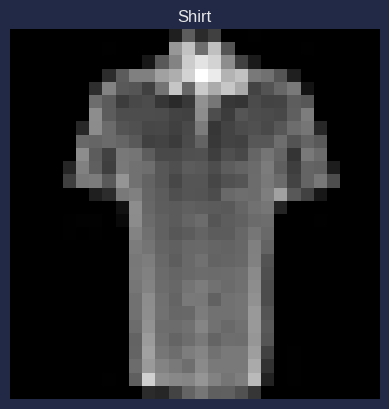

In [14]:
torch.manual_seed(42)
rand_idx = torch.randint(0 , len(train_features_batch), size=[1]).item()
img ,  label = train_features_batch[rand_idx] , train_labels_batch[rand_idx]
plt.imshow(img.squeeze(),cmap='gray')
plt.title(class_label[label])
plt.axis(False)

# Model 0 : BaseLine Model

When starting to build a series of ML modeling experiments . Its best practice to start with a baseline model.

BaseLine model is simple model you will try and improve upon with subsequent experimentation

In other words start simply and complexity when necessary

In [15]:
# Creating a flatten layer
flatten_model = nn.Flatten()

# Get a single sample
x = train_features_batch[0]

# Flatten the sample
output  =  flatten_model(x) #perform forward pass

# we simply want to convert the data from the image pattern to an array so we can give it in a Fully connected layer
# and give to the models as in the begining we are using linear model

output.squeeze().shape , x.shape

(torch.Size([784]), torch.Size([1, 28, 28]))

In [16]:
class FashionMINSTModelVO(nn.Module):
  def __init__(self, input_shape: int , hidden_unit: int , output_shape:int):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=input_shape , out_features=hidden_unit),
        nn.Linear(in_features=hidden_unit , out_features= output_shape)
    )

  def forward(self , x):
    return self.layer_stack(x)

In [17]:
torch.manual_seed(42)

# setup model with input parameters
model_O = FashionMINSTModelVO(
    input_shape=784 , # this is 28*28
    hidden_unit= 10 , # how many layers in the hidden units
    output_shape = len(class_label)
).to("cpu")

In [18]:
model_O

FashionMINSTModelVO(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [19]:
dummy_x = torch.rand([1,1,28,28])
model_O(dummy_x)


tensor([[-0.0315,  0.3171,  0.0531, -0.2525,  0.5959,  0.2112,  0.3233,  0.2694,
         -0.1004,  0.0157]], grad_fn=<AddmmBackward0>)

In [20]:
model_O.state_dict()

OrderedDict([('layer_stack.1.weight',
              tensor([[ 0.0273,  0.0296, -0.0084,  ..., -0.0142,  0.0093,  0.0135],
                      [-0.0188, -0.0354,  0.0187,  ..., -0.0106, -0.0001,  0.0115],
                      [-0.0008,  0.0017,  0.0045,  ..., -0.0127, -0.0188,  0.0059],
                      ...,
                      [-0.0116,  0.0273, -0.0344,  ...,  0.0176,  0.0283, -0.0011],
                      [-0.0230,  0.0257,  0.0291,  ..., -0.0187, -0.0087,  0.0001],
                      [ 0.0176, -0.0147,  0.0053,  ..., -0.0336, -0.0221,  0.0205]])),
             ('layer_stack.1.bias',
              tensor([-0.0093,  0.0283, -0.0033,  0.0255,  0.0017,  0.0037, -0.0302, -0.0123,
                       0.0018,  0.0163])),
             ('layer_stack.2.weight',
              tensor([[ 0.0614, -0.0687,  0.0021,  0.2718,  0.2109,  0.1079, -0.2279, -0.1063,
                        0.2019,  0.2847],
                      [-0.1495,  0.1344, -0.0740,  0.2006, -0.0475, -0.2514, -0.

# Setup loss , optimizer and evaluation metrics

* loss function - Since we are working wiht the multiclass classification data our loss fucntion will be `nn.CrossEntropy()`

* Optimizer - our optimizer `torch.optim.SGD()`

* Evaluation Metric - since we are woeking on a classification , let use accuracy as our evaluation metric


In [21]:
import requests
from pathlib import Path

# Download helper function from learn Pytorch repo
if Path("helper_functions.py").is_file():
  print("Exists")
else:
  print("Downloading")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py",'wb') as f:
    f.write(request.content)

Downloading


In [22]:
from helper_functions import accuracy_fn

In [23]:
# set up loss function and optimizer

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(
    params = model_O.parameters(),
    lr = 0.1
)

# create a funciton to time our experiments

Two main things ML engineer often want to track are :

* Model 's performance

* how fast it runs


In [24]:
from timeit import default_timer as timer
def print_train_timer(start:float, end:float , device: torch.device=None):
  """Print difference between start and end time"""
  total_time = end-start
  print(
      f"train time on {device}: {total_time:.3f} seconds"
  )

# Creating a training loop and training our model on batches of data

1. loop through epochs.

2. loop through training batches, perform training steps , calculate the train loss *per batch*

3. loop through testing batches , perform testing steps , calculate the test loss *per batch*

4. Print out whats hapenning

5. Time it all

In [25]:
from tqdm.auto import tqdm # for progress bar

# set the seed and start the timer
torch.manual_seed(42)
train_time_start_on_cpu = timer()

# set the no. of epochs
epochs = 3

# Create the training and test loop
for epoch in tqdm(range(epochs)):
  print(f"Epoch : {epoch}\n--------")
  #Training
  train_loss = 0
  # add a loop to through the training batches
  for batch, (X,y) in enumerate(train_dataloader):
    model_O.train()
    #1. Forward pass
    y_pred = model_O(X)

    # Calculate loss (per batch)
    loss = loss_fn(y_pred,y)
    train_loss += loss # accumulate train loss

    # optimizer zero grad
    optimizer.zero_grad()

    #loss backward
    loss.backward()

    # Optimizer step
    optimizer.step()

    # Print out whats happening
    if batch % 400 ==0:
      print(f"looked at {batch*len(X)} / {len(train_dataloader.dataset)} samples")

  # Divide total train loss by length of train dataloader
  train_loss /= len(train_dataloader)

  # Testing
  test_loss, test_acc = 0,0
  model_O.eval()
  with torch.inference_mode():
    for X_test , y_test in test_dataloader:
      # 1. forward pass
      test_pred = model_O(X_test)

      # calculate loss (accumulatively)
      test_loss+= loss_fn(test_pred,y_test)

      # 3. Calculate the accuracy
      test_acc += accuracy_fn(y_true=y_test , y_pred=test_pred.argmax(dim=1))

    # Calculate the test loss average per batch
    test_loss /= len(test_dataloader)

    # Calculate the test accuracy average per batch
    test_acc /= len(test_dataloader)

  # print out whats happening
  print(f"\nTrain loss : {train_loss:.4f} | | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%\n")




# Calculate training time
train_time_end_on_cpu = timer()
total_train_time_model_O = print_train_timer(start=train_time_start_on_cpu,
                                           end=train_time_end_on_cpu,
                                           device=str(next(model_O.parameters()).device)
                                           )

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 0
--------
looked at 0 / 60000 samples
looked at 12800 / 60000 samples
looked at 25600 / 60000 samples
looked at 38400 / 60000 samples
looked at 51200 / 60000 samples

Train loss : 0.5904 | | Test loss: 0.51016, Test acc: 82.04%

Epoch : 1
--------
looked at 0 / 60000 samples
looked at 12800 / 60000 samples
looked at 25600 / 60000 samples
looked at 38400 / 60000 samples
looked at 51200 / 60000 samples

Train loss : 0.4743 | | Test loss: 0.52677, Test acc: 81.68%

Epoch : 2
--------
looked at 0 / 60000 samples
looked at 12800 / 60000 samples
looked at 25600 / 60000 samples
looked at 38400 / 60000 samples
looked at 51200 / 60000 samples

Train loss : 0.4537 | | Test loss: 0.51264, Test acc: 83.00%

train time on cpu: 36.861 seconds


# Make prediction and get model_0 results

In [26]:
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.dataloader,
               loss_fn: torch.nn.Module,
               accuracy_fn):
  """Return a dictionay containing the results of model predicting on data_loader"""

  loss , acc = 0,0
  model.to('cpu')
  with torch.inference_mode():
    for X, y in tqdm(data_loader):
      # make prediction
      y_pred = model(X)

      # Accumulate the loss and acc values per batch
      loss += loss_fn(y_pred,y)
      acc += accuracy_fn(y_true=y,
                         y_pred=y_pred.argmax(dim=1))

    #Scale the loss and acc to find the avg loss and acc per batch
    loss /= len(data_loader)
    acc /= len(data_loader)

    return {"model_name": model.__class__.__name__, # only works when models are created using class
            "model_loss": loss.item(),
            "model_acc": acc}

# calculate model_0 results on test dataset
model_O_results = eval_model(model=model_O,
                             data_loader=test_dataloader,
                             loss_fn = loss_fn,
                             accuracy_fn= accuracy_fn)
model_O_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMINSTModelVO',
 'model_loss': 0.5121424198150635,
 'model_acc': 83.00718849840256}

# 5. Setup device agnostic-code (for using a GPU if there is one )

In [27]:
torch.cuda.is_available()

True

In [28]:
!nvidia-smi

Tue Oct 24 04:37:32 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8     9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [29]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# MOdel 1 : Building the model with a non-linearity

In [30]:
class FashionMINSTModelV1(nn.Module):
  def __init__(self, input_shape: int , hidden_unit: int , output_shape:int):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=input_shape , out_features=hidden_unit),
        nn.ReLU(),
        nn.Linear(in_features=hidden_unit , out_features= output_shape),
        nn.ReLU()
    )

  def forward(self , x:torch.Tensor):
    return self.layer_stack(x)

In [31]:
# Create object of model1
torch.manual_seed(42)
model_1 = FashionMINSTModelV1(input_shape=784,
                              hidden_unit=10,
                              output_shape=len(class_label)).to(device)

In [32]:
# picking up the loss function and the optimizer
# set up loss function and optimizer

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(
    params = model_1.parameters(),
    lr = 0.1
)


# Training and evaluation loop

lets create a function for :
* training loop - `train_step()`
* testing loop - `test_step()`

In [33]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    train_loss, train_acc = 0, 0
    model.to(device)
    for batch, (X, y) in enumerate(data_loader):
        # Send data to GPU
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y,
                                 y_pred=y_pred.argmax(dim=1)) # Go from logits -> pred labels

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    # Calculate loss and accuracy per epoch and print out what's happening
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

def test_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    test_loss, test_acc = 0, 0
    model.eval() # put model in eval mode
    # Turn on inference context manager
    with torch.inference_mode():
        for X, y in data_loader:
            # Send data to GPU
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred = model(X)

            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y,
                y_pred=test_pred.argmax(dim=1) # Go from logits -> pred labels
            )

        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

# Building the training/testing loop with the 2 methods for training and testing

In [34]:
device

'cuda'

In [35]:
torch.manual_seed(42)

# Measure time
from timeit import default_timer as timer
train_time_start_on_gpu = timer()

epochs = 3
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_step(data_loader=train_dataloader,
        model=model_1,
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn
    )
    test_step(data_loader=test_dataloader,
        model=model_1,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn
    )

train_time_end_on_gpu = timer()
total_train_time_model_1 = print_train_timer(start=train_time_start_on_gpu,
                                            end=train_time_end_on_gpu,
                                            device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 1.09199 | Train accuracy: 61.34%
Test loss: 0.95690 | Test accuracy: 64.98%

Epoch: 1
---------
Train loss: 0.73779 | Train accuracy: 73.69%
Test loss: 0.72388 | Test accuracy: 74.21%

Epoch: 2
---------
Train loss: 0.66776 | Train accuracy: 76.08%
Test loss: 0.68751 | Test accuracy: 75.64%

train time on cuda: 33.053 seconds


In [36]:
eval_model(model_1,test_dataloader,loss_fn,accuracy_fn)

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMINSTModelV1',
 'model_loss': 0.6874653100967407,
 'model_acc': 75.64896166134186}

# Model 2: Building a Convolutinal Neural Network

CNN also known as convnets

CNN are known for their capabilities to find pattern in visual datamm

In [37]:
# Create a CNN

class FashionMINSTModelV2(nn.Module):
  """Model architecture that replicates the tinyVGG model from CNN Explainer website"""

  def __init__(self,input_shape, hidden_units, output_shape):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape, out_channels = hidden_units,
                  kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units, out_channels = hidden_units,
                  kernel_size=3, stride=1, padding=1),
        # nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units, out_channels = hidden_units,
                  kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units, out_channels = hidden_units,
                  kernel_size=3, stride=1, padding=1),
        # nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*7*7,
                  out_features=output_shape)
    )

  def forward(self,x):
    x = self.conv_block_1(x)
    # print(x.shape)
    x = self.conv_block_2(x)
    # print(x.shape)
    x = self.classifier(x)
    return x

In [38]:
device , img.shape

('cuda', torch.Size([1, 28, 28]))

In [39]:
torch.manual_seed(42)
model_2 = FashionMINSTModelV2(input_shape= 1,# same as the no. of color channels in our image
                              hidden_units= 15,
                              output_shape=len(class_label)).to(device)

# Understanding how the operation is carried out in convolutional layer

In [40]:
torch.manual_seed(42)

# create a batch of images
images = torch.randn(size=(32,3,28,28))
test_image = images[0]
test_image.shape

torch.Size([3, 28, 28])

In [41]:
 # Create a single conv2d layer
 conv_2d_2d = nn.Conv2d(
    in_channels=3,
    out_channels=10,
    kernel_size=3,
    stride=1,
    padding=1
 )

In [42]:
conv_2d_2d(test_image).shape

torch.Size([10, 28, 28])

# Going through `nn.Maxpool2d()`

In [43]:
test_image.shape

torch.Size([3, 28, 28])

In [44]:
maxpool = nn.MaxPool2d(kernel_size=2,stride=2)
maxpool(test_image).shape

torch.Size([3, 14, 14])

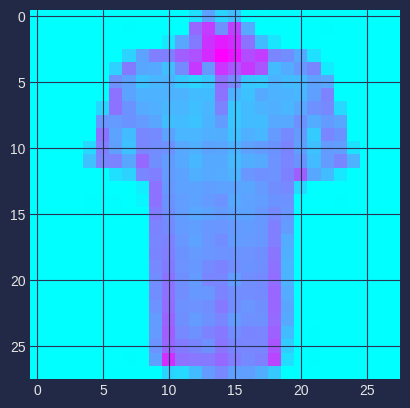

In [45]:
plt.imshow(img.squeeze())

In [46]:
model_2(torch.randn(size=(1,1,28,28)).to(device))

tensor([[ 0.0265,  0.0319, -0.0282, -0.0255, -0.0012, -0.0260,  0.0991,  0.0264,
         -0.0625, -0.0333]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [47]:
class_label

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [48]:
# setup a loss function and optimizer

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_2.parameters(),
                            lr=0.1)

In [49]:
# train test loop
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Measure time
from timeit import default_timer as timer
train_time_start_on_gpu = timer()

epochs = 6
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_step(data_loader=train_dataloader,
        model=model_2,
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn,
        device=device
    )
    test_step(data_loader=test_dataloader,
        model=model_2,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn
    )

train_time_end_on_gpu = timer()
total_train_time_model_1 = print_train_timer(start=train_time_start_on_gpu,
                                            end=train_time_end_on_gpu,
                                            device=device)

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 0.49836 | Train accuracy: 81.80%
Test loss: 0.35394 | Test accuracy: 87.17%

Epoch: 1
---------
Train loss: 0.31491 | Train accuracy: 88.62%
Test loss: 0.35501 | Test accuracy: 87.33%

Epoch: 2
---------
Train loss: 0.27688 | Train accuracy: 90.07%
Test loss: 0.29504 | Test accuracy: 89.30%

Epoch: 3
---------
Train loss: 0.25780 | Train accuracy: 90.76%
Test loss: 0.27834 | Test accuracy: 90.07%

Epoch: 4
---------
Train loss: 0.24466 | Train accuracy: 91.27%
Test loss: 0.26582 | Test accuracy: 90.58%

Epoch: 5
---------
Train loss: 0.23343 | Train accuracy: 91.55%
Test loss: 0.26864 | Test accuracy: 90.46%

train time on cuda: 69.488 seconds


In [50]:
eval_model(model_2,test_dataloader,loss_fn,accuracy_fn)

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMINSTModelV2',
 'model_loss': 0.26882821321487427,
 'model_acc': 90.435303514377}

In [51]:
model_2(img.unsqueeze(dim=1)).argmax()# 6

tensor(6)

In [52]:
img.unsqueeze(dim=1).shape

torch.Size([1, 1, 28, 28])

In [53]:
class_label[int(model_2(img.unsqueeze(dim=1)).argmax())]

'Shirt'

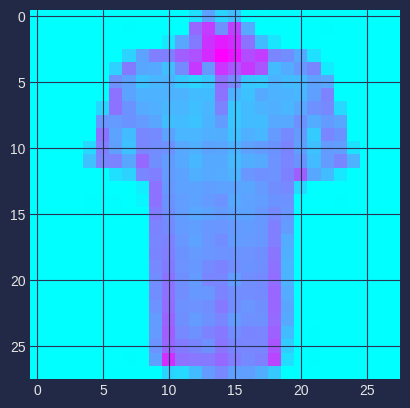

In [54]:
plt.imshow(img.squeeze())

Model predicted 0 and the label is 0
Model predicted 1 and the label is 1
Model predicted 3 and the label is 3
Model predicted 0 and the label is 0
Model predicted 5 and the label is 5
Model predicted 3 and the label is 3
Model predicted 8 and the label is 8
Model predicted 2 and the label is 4
Model predicted 2 and the label is 2
Model predicted 1 and the label is 1


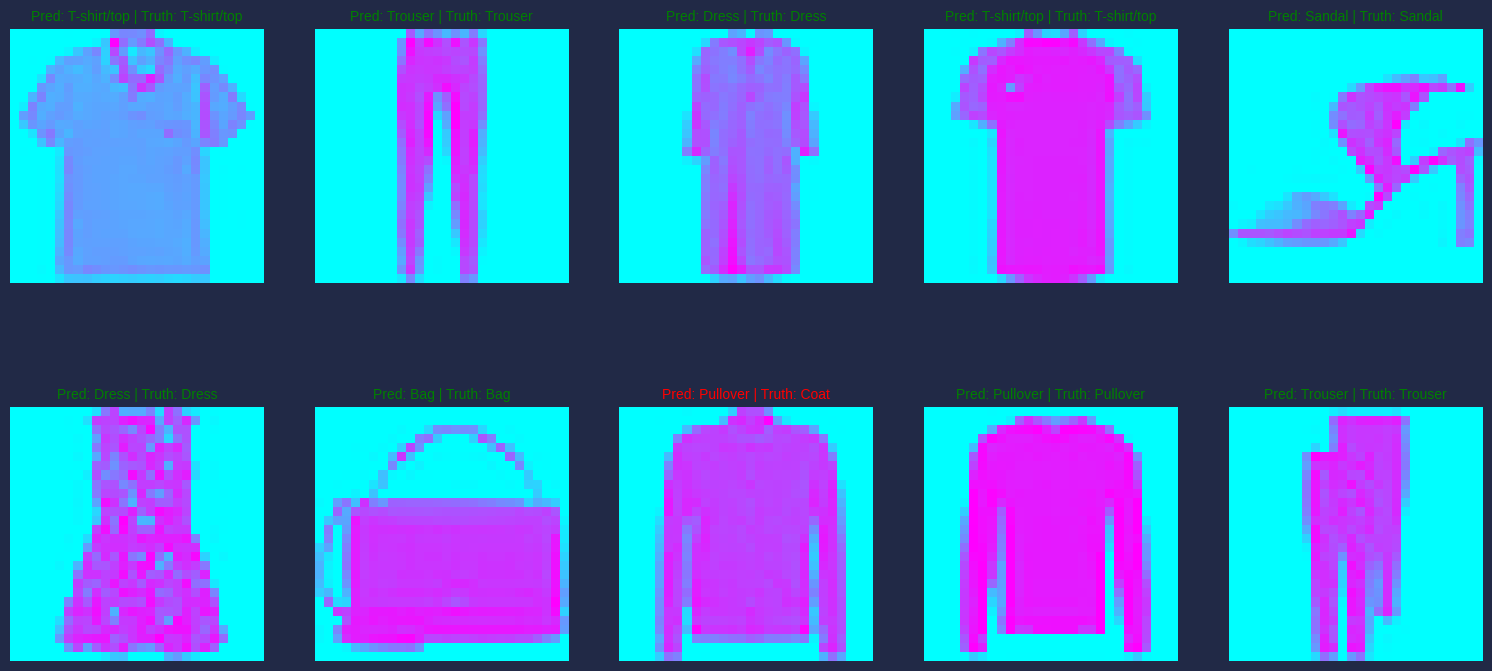

In [94]:
# Making prediction from the test dataset
labels = []
model_preds = []
plt.figure(figsize=(19,9))
nrows = 2
ncols = 5
for i in range(0,10):
  random_idx = torch.randint(low = 0,high = len(train_data),size=[1]).item()
  img , label = train_data[random_idx]
  model_pred = model_2(img.unsqueeze(dim=1)).argmax()
  # labels.append(label)
  # model_preds.append(model_pred)
  plt.subplot(nrows, ncols, i+1)
  plt.imshow(img.squeeze())
  # Check for equality and change title colour accordingly
  if model_pred == label:
      plt.title(f"Pred: {class_label[model_pred]} | Truth: {class_label[label]}", fontsize=10, c="g") # green text if correct
  else:
      plt.title(f"Pred: {class_label[model_pred]} | Truth: {class_label[label]}", fontsize=10, c="r") # red text if wrong


  print(f"Model predicted {model_pred} and the label is {label}")

  plt.axis(False)

In [79]:
class_label[0],class_label[8],class_label[6]

('T-shirt/top', 'Bag', 'Shirt')

In [77]:
class_label[3],class_label[4]

('Dress', 'Coat')

In [82]:
class_label[9],class_label[8-1]

('Ankle boot', 'Sneaker')